In [1]:
from cpa_utils import *

# Elisabeth-b4 - Filter block

## Attacking the filter S-boxes

In [2]:
traces_path = "..\\acquisition\\carto_eB4-Rnd-3-WhiteningAndFullFilter-125000_samples_alternating_same_and_varying_fixed_second_round\\carto_eB4-Rnd-3-WhiteningAndFullFilter-Alternating-Same-And-Varying-Seeds.mat"
key_path = "..\\acquisition\\carto_eB4-Rnd-3-WhiteningAndFullFilter-125000_samples_alternating_same_and_varying_fixed_second_round\\carto_eB4-Rnd-3-WhiteningAndFullFilter-Alternating-Same-And-Varying-Seeds.log"

In [3]:
_, _, seeds_varying, traces_varying, real_keys = load_data_alternating_same_varying(traces_path, key_path)

In [15]:
def single_bit_differential_trace_for_key_index(total_seeds: np.ndarray, total_traces: np.ndarray) -> np.ndarray:
    group_0 = np.zeros((KEY_WIDTH_B4, 16, total_traces.shape[1]), dtype=np.float32)
    group_0_card = 0
    group_1 = np.zeros((KEY_WIDTH_B4, 16, total_traces.shape[1]), dtype=np.float32)
    group_1_card = 0

    for i, iv in enumerate(total_seeds):
        indices, whitening = chacha_random_b4(iv)
        for round_idx in range(12, 13):
            block_idx = 4
            keyround_idx = round_idx * BLOCK_WIDTH_B4 + block_idx

            key_target_idx = indices[keyround_idx]  

            for k in range(16): 
                sbox_in = (k + whitening[keyround_idx]) % 16
                sbox_out = s_boxes_b4[block_idx][sbox_in]

                if sbox_out & 1 == 0:
                    group_0[key_target_idx, k] += total_traces[i]
                    group_0_card += 1
                else:
                    group_1[key_target_idx, k] += total_traces[i]
                    group_1_card += 1
    diff = group_0 / group_0_card - group_1 / group_1_card

    return diff

Key 0: 

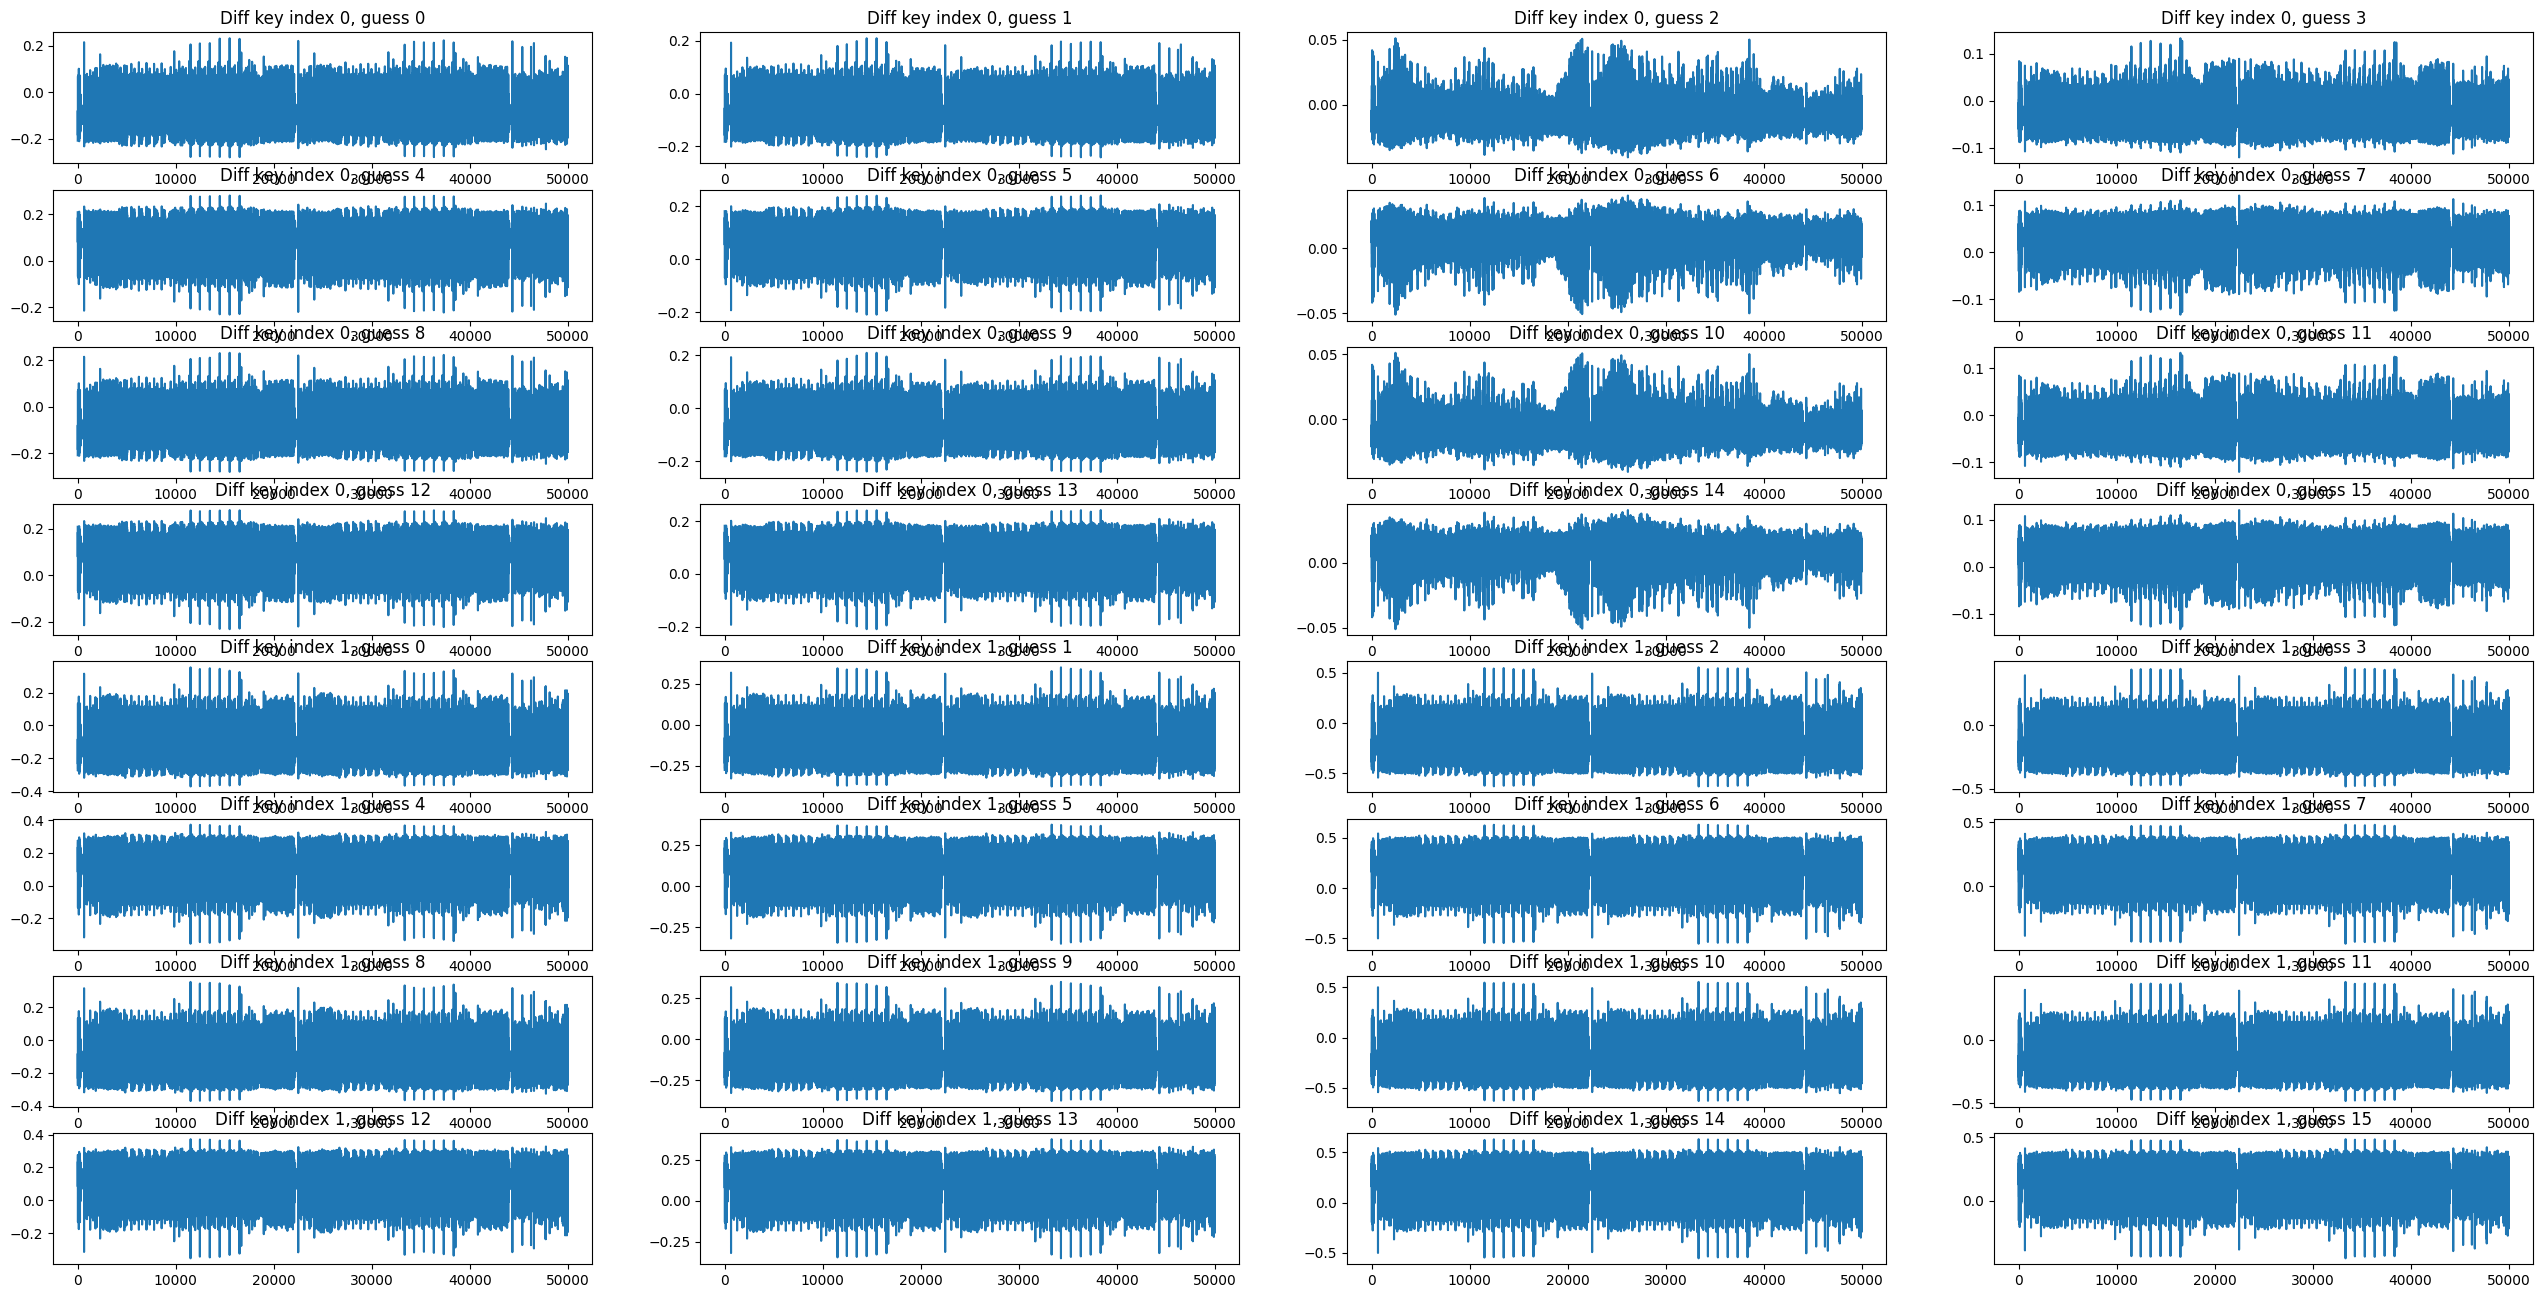


    vs 0B16AC227F7BD0DE135F326030CA503A6D7532A6C1FFA3288DD0436021DABBD210BAA538BEED7D830E4FF9A848868C5CD73A94425573EEB245ADDC25D4A0E814DF6BDB65C3937D805F5EEB53FC0314EEB0443D6C8B0B76806A5F16DAFE093BE4B221C240220DA15F89683EE416F2B4DF26925B30AA70E49C474D8E6B2E78CB358718E71DA044F60A5475A11B1B7BB6D494CD8E314B689B11DD23AB5826FB5140D93E48D5B80785C73B66B3F5CE0FA5C25057C0FF8326E31ABF9157B6F3AAA193952A85ABE468EB0B2BAD08AF7BA48D2FB0AD27E2BF311EE94CE7FF7E09A23B4CD97ABB12583C20A362AC96F284AABA21AABF15E0B457CFFD2BF31EDAACD3F1A7
479 mistakes on 512 nibbles.



In [16]:
reconstructed_keys = np.zeros_like(real_keys)
for i in range(reconstructed_keys.shape[0]):
    print(f"Key {i}: ", end="")
    diffs = single_bit_differential_trace_for_key_index(seeds_varying[i], traces_varying[i])
    fig, axs = plt.subplots(4*2, 4, figsize=(32, 16))
    for k in range(2):
        for j in range(4):
            for l in range(4):
                axs[4*k + j, l].plot(diffs[k, 4*j + l])
                axs[4*k + j, l].set_title(f"Diff key index {k}, guess {4*j + l}")
    plt.show()
        
    print()
    print(f"    vs {"".join([hex(k)[2:].upper() for k in real_keys[i]])}")
    print(f"{len(real_keys[i][real_keys[i] != reconstructed_keys[i]])} mistakes on {len(real_keys[i])} nibbles.")
    print()